In [3]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant
from scipy.linalg import toeplitz, hankel
from IPython.display import clear_output
from scipy.linalg import expm
import pickle


#### --------- Definition of variables ------------------------

N_size=500001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------
def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f


display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))


def Get_Bands_Matrix(N_size,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        M_minous=[((m_cos[np.abs(int(i))]-m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        M_plus = [((m_cos[np.abs(int(i))]+m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        Mminousband=np.array(M_minous)
        Mplusband=np.array(M_plus)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,n=i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,n=i) else 0.5 for i in x]
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)

        M_minous=[((m_cos[np.abs(int(i))]-m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        M_plus = [((m_cos[np.abs(int(i))]+m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        Mminousband=np.array(M_minous)
        Mplusband=np.array(M_plus)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fft(ifftshift(Mplusband))
    Fourier_minous=fft(ifftshift(Mminousband))
    return Fourier_plus/N_size,Fourier_minous/N_size

def Toeplitz_matrix(Fourier_plus,L):
    First_column = Fourier_plus[:L]
    First_row = np.roll(Fourier_plus,-1)[::-1][:L]
    return toeplitz(First_column,First_row)
def Hankel_matrix(Fourier_minous,L):
    to_use=Fourier_minous[:2*L-1]
    First_column=to_use[:L]
    Last_row=np.roll(to_use,-L+1)[:L]
    return hankel(First_column,Last_row)

def Covariance_matrix(L,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,N_size=N_size,Ground=False):
    if Ground:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=True)
    else:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=False)
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))

def Covariance_matrix_from_sub_sample(Fourier_plus,Fourier_minous,L):
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))


def print_progress(total,step,num=50):
    message="["+"="*int(num*((step/total)))+" "*int(num*(1-(step/total)))+"]"
    message+="  "+str(round(step/total*100,3))+ " "+ "%"
    print(message,end="\r")
    
def get_band_of_matrix(Matrix,num_band):
    L,C=Matrix.shape
    if L!=C:
        raise ValueError("Only squared matrix can be computed")
    if num_band > 0:
        return np.array([[Matrix[i,j] for i in range(num_band,L) if i-j == num_band] for j in range(L-num_band)]).reshape(L-num_band)
    elif num_band <0:
        return np.array([[Matrix[i,j] for i in range(L) if i-j == num_band] for j in range(-num_band,L)]).reshape(L+num_band)
    else:
        return np.diagonal(Matrix)

In [2]:
a,b=Get_Bands_Matrix(N_size=1000)
a_0=Lambda
a_1=0.5*(1-Gamma)
a_2=0.5*(1+Gamma)
alpha=0.5

In [3]:
L=301
New_cov_matrix=Covariance_matrix_from_sub_sample(a,b,L)

In [4]:
S_2 = np.linalg.svd(New_cov_matrix.real,compute_uv=False)

S_t=[]
for i in np.linspace(0,1):
    alpha=i
    M_corner=np.zeros((L,L))
    M_corner[0,L-1],M_corner[L-1,0]=alpha*New_cov_matrix[1,0].real,alpha*New_cov_matrix[0,1].real
    S_1 = np.linalg.svd(New_cov_matrix.real+M_corner,compute_uv=False)
    S_t.append(S_1)
    #plt.plot(S_1)

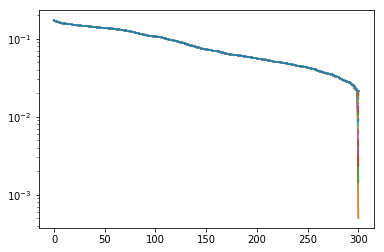

In [43]:
plt.plot(S_2)
for i in range(len(S_t)):
    plt.plot(S_t[i])
plt.yscale("log")
plt.show()

33


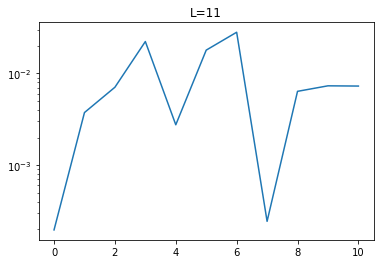

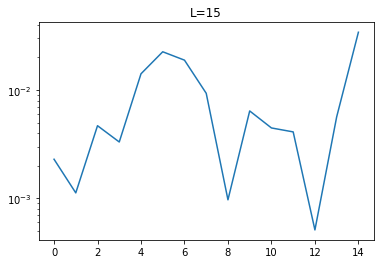

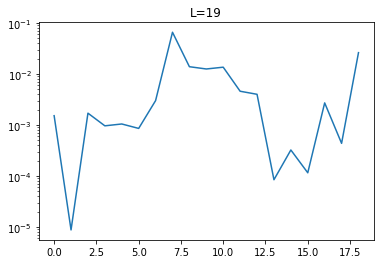

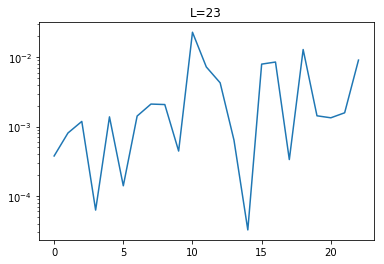

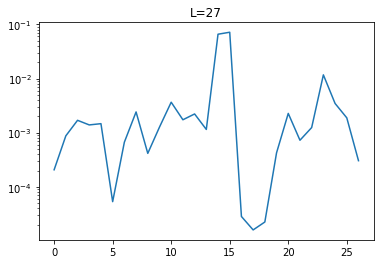

73


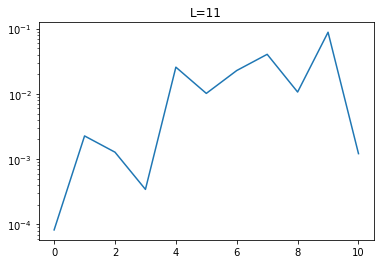

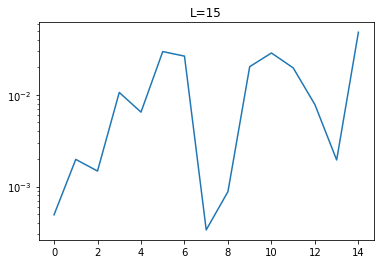

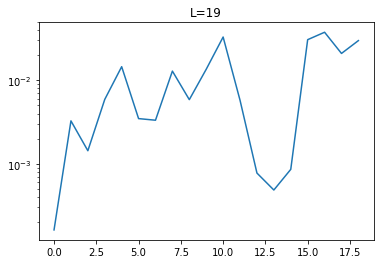

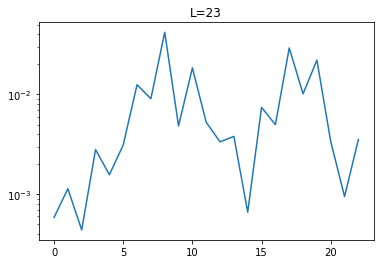

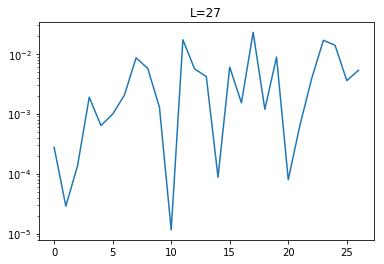

165


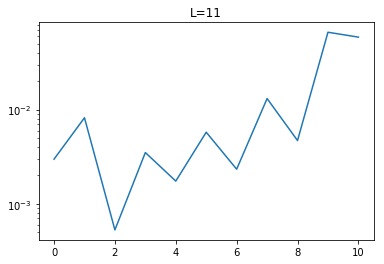

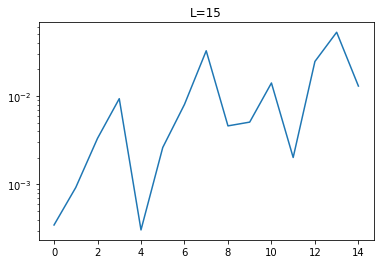

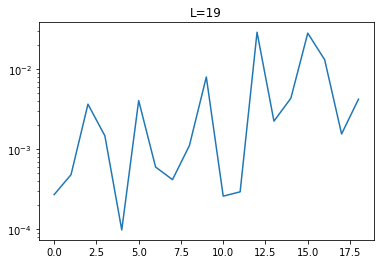

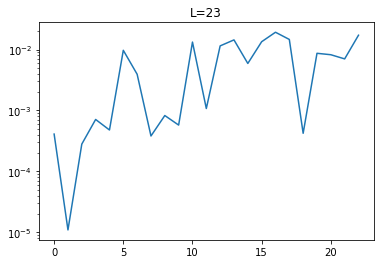

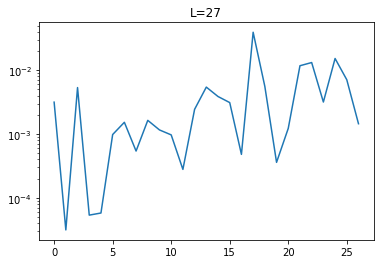

374


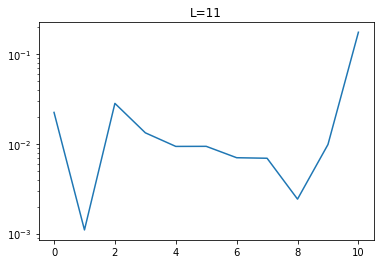

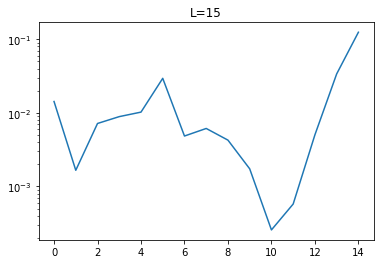

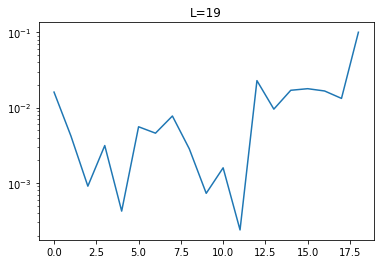

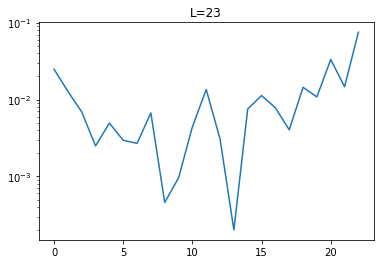

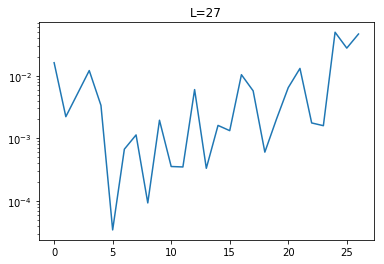

848


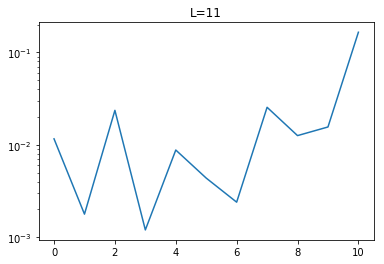

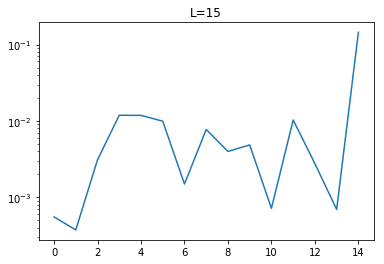

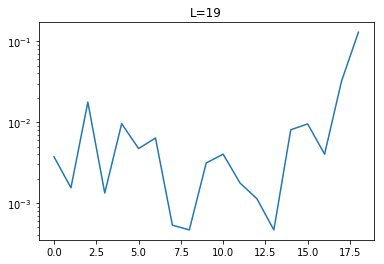

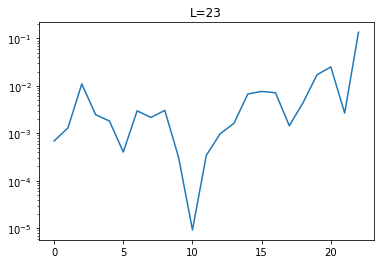

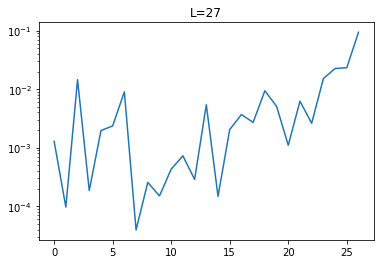

1923


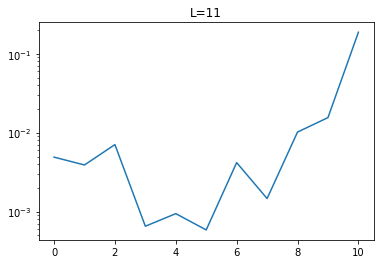

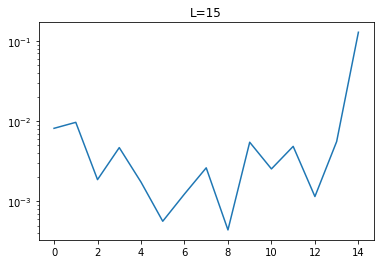

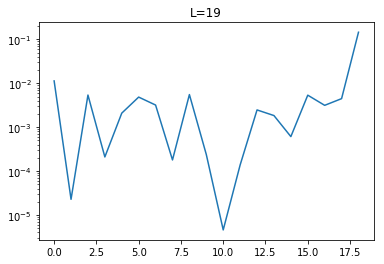

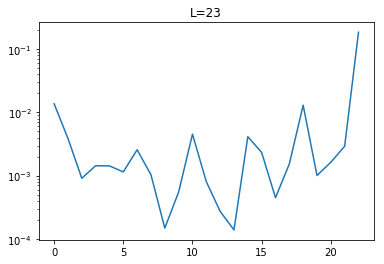

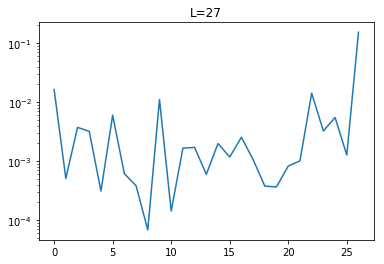

4363


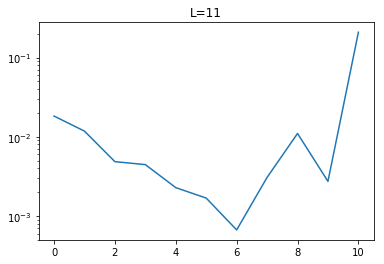

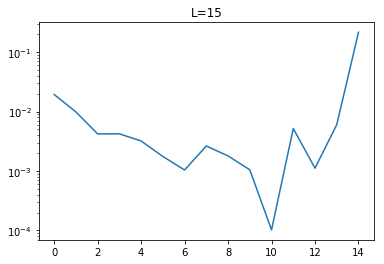

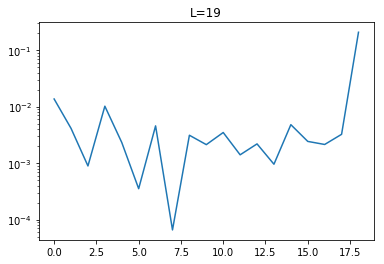

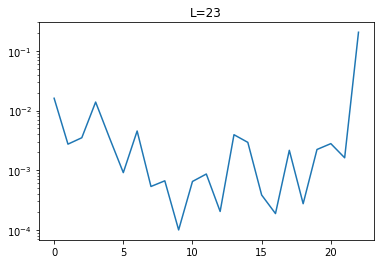

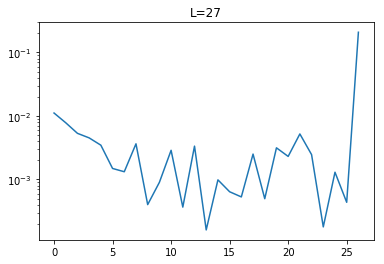

9897


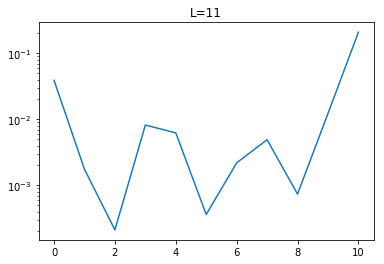

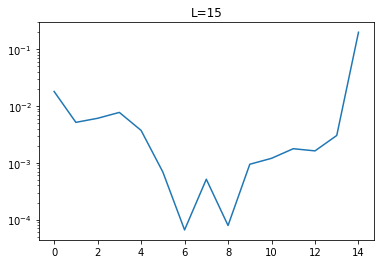

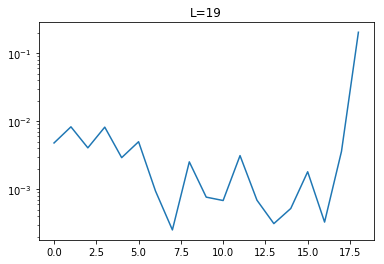

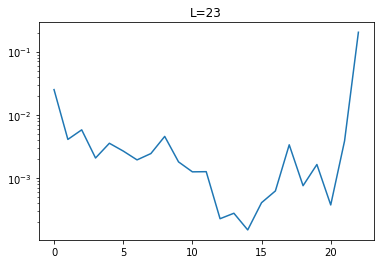

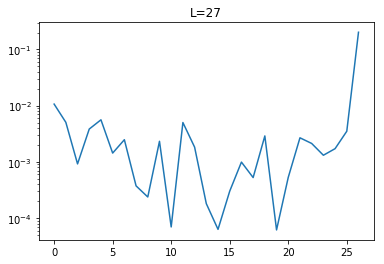

22452


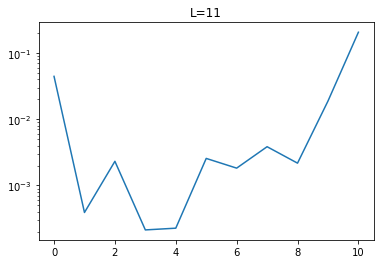

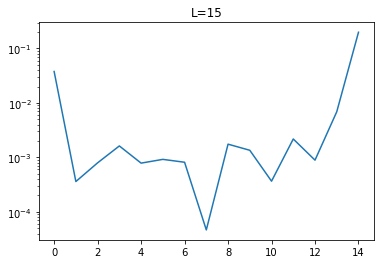

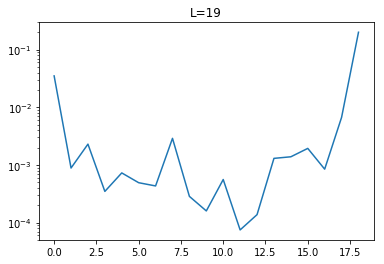

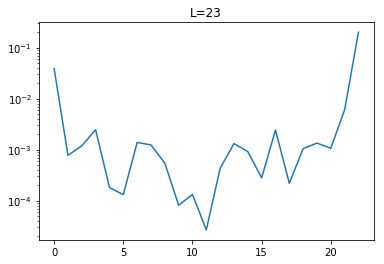

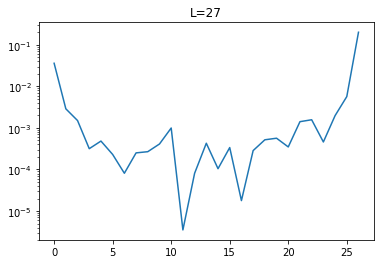

50935


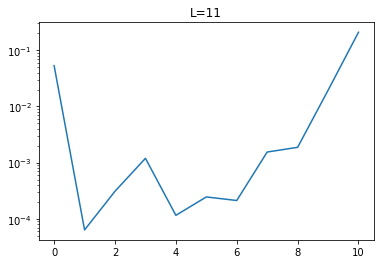

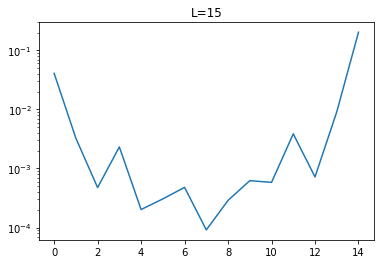

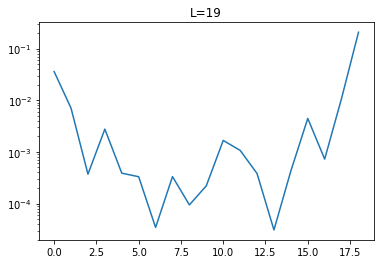

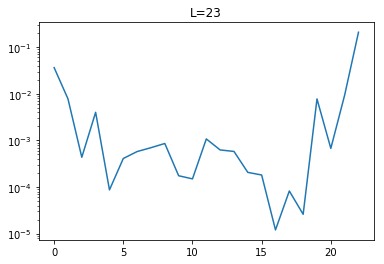

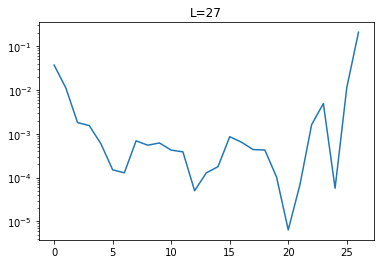

115552


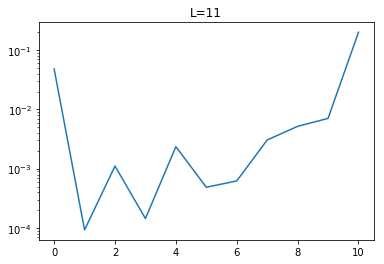

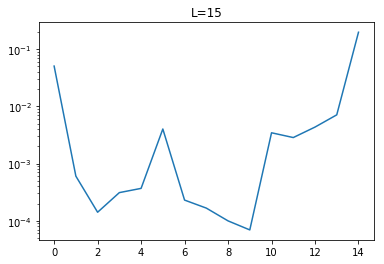

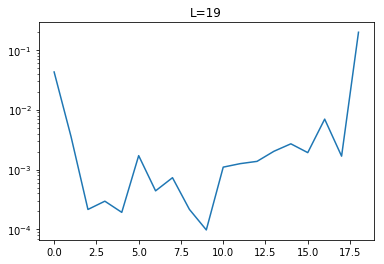

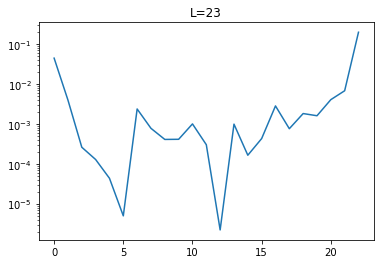

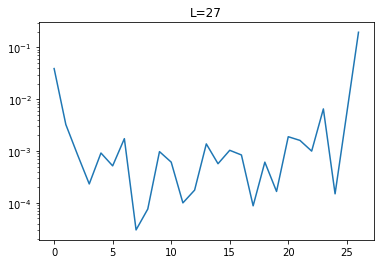

262145


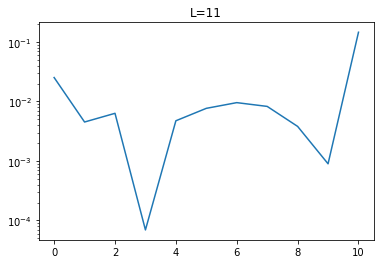

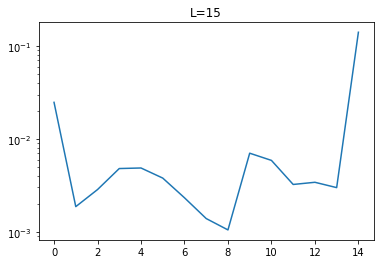

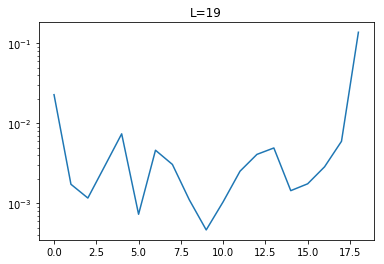

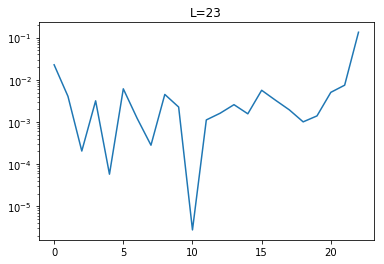

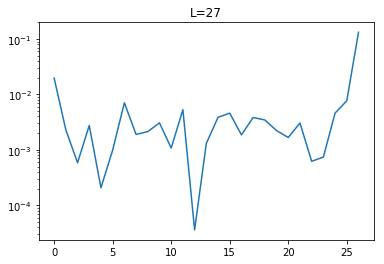

In [93]:
for size in np.logspace(5,18,base=2,num=12):
    print(int(size)+1)
    A,B=Get_Bands_Matrix(N_size=int(size)+1)
    for test in range(99):
        a,b=Get_Bands_Matrix(N_size=int(size)+1)
        A+=a/100
        B+=b/100
    for L in range(11,31,4):
        #print(L)
        New_cov_matrix=Covariance_matrix_from_sub_sample(A,B,L=L)
        S_2 = np.linalg.svd(New_cov_matrix.real,compute_uv=False)
        alpha=1
        #print(New_cov_matrix.shape)
        M_corner=np.zeros((L,L))
        #print(M_corner.shape)
        M_corner[0,L-1],M_corner[L-1,0]=alpha*New_cov_matrix[1,0].real,alpha*New_cov_matrix[0,1].real
        S_1 = np.linalg.svd(New_cov_matrix.real+M_corner,compute_uv=False)
        plt.plot(np.abs(S_1-S_2))
        plt.yscale("log")
        plt.title("L={}".format(L))
        plt.show()

In [89]:
2**18

262144

In [83]:
M_corner.shape

(37, 37)

In [75]:
for i in np.logspace(5,18,base=2,num=12):
    print(int(i)+1)

33
73
165
374
848
1923
4363
9897
22452
50935
115552
262145


In [95]:
with open('data_50k.pkl', 'rb') as File:
    Data=pickle.load(File)

# Averganing

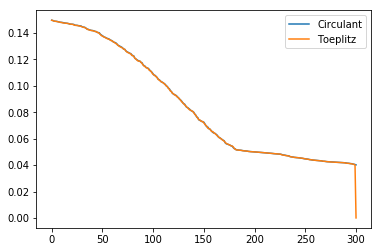

In [96]:
L=301
New_cov_matrix=Covariance_matrix_from_sub_sample(Data[:,:,0].mean(axis=0),Data[:,:,1].mean(axis=0),L=L)
S_2 = np.linalg.svd(New_cov_matrix.real,compute_uv=False)
M_corner=np.zeros((L,L))
M_corner[0,L-1],M_corner[L-1,0]=New_cov_matrix[1,0].real, New_cov_matrix[0,1].real
S_1 = np.linalg.svd(New_cov_matrix.real+M_corner,compute_uv=False)

plt.plot(S_1,label="Circulant")
plt.plot(S_2,label="Toeplitz")
plt.legend()

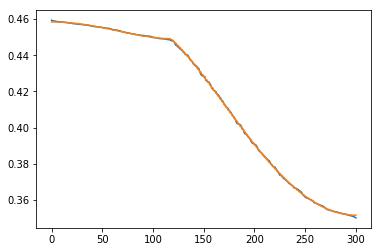

In [9]:
plt.plot(sorted(-S_1+0.5,reverse=True))
n=np.arange(-(L-1)/2,(L-1)/2 +1)
f=Fermi_dirac(beta=0.40824,mu=0,n=n,Gamma=Gamma,Lambda=Lambda,N=L)
plt.plot(sorted(f,reverse=True))

# Over a single sample

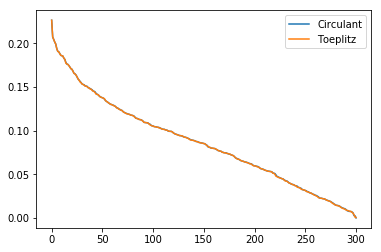

In [98]:
L=301
New_cov_matrix=Covariance_matrix_from_sub_sample(Data[1,:,0],Data[1,:,1],L=L)
S_2 = np.linalg.svd(New_cov_matrix.real,compute_uv=False)
M_corner=np.zeros((L,L))
M_corner[0,L-1],M_corner[L-1,0]=New_cov_matrix[1,0].real, New_cov_matrix[0,1].real
S_1 = np.linalg.svd(New_cov_matrix.real+M_corner,compute_uv=False)
plt.plot(S_1,label="Circulant")
plt.plot(S_2,label="Toeplitz")
plt.legend()
plt.show()

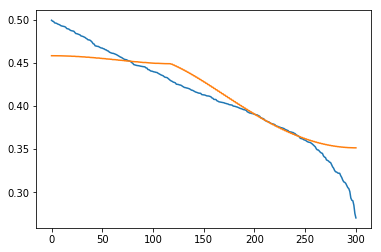

In [12]:
plt.plot(sorted(-S_1+0.5,reverse=True))
n=np.arange(-(L-1)/2,(L-1)/2 +1)
f=Fermi_dirac(beta=0.40824,mu=0,n=n,Gamma=Gamma,Lambda=Lambda,N=L)
plt.plot(sorted(f,reverse=True))

# looking at fluctuations

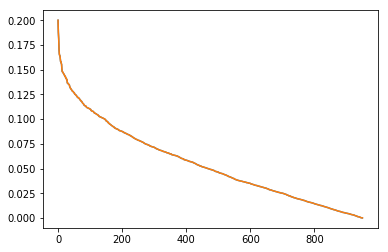

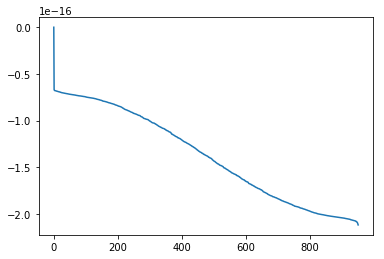

In [101]:
L=951
New_cov_matrix_avg=Covariance_matrix_from_sub_sample(Data[:,:,0].mean(axis=0),Data[:,:,1].mean(axis=0),L=L)
New_cov_matrix=Covariance_matrix_from_sub_sample(Data[0,:,0],Data[0,:,1],L=L)

S_test=np.linalg.svd(New_cov_matrix-New_cov_matrix_avg,compute_uv=False)

New_cov_matrix_test=Covariance_matrix_from_sub_sample(Data[0,:,0]-Data[:,:,0].mean(axis=0),Data[0,:,1]-Data[:,:,1].mean(axis=0),L=L)

S_diff=np.linalg.svd(New_cov_matrix_test,compute_uv=False)

plt.plot(S_test)
plt.plot(S_diff)
plt.show()

std_plus,std_minous=np.mean(Data[:,:,0]-Data[:,:,0].mean(axis=0),axis=0),np.mean(Data[:,:,1]-Data[:,:,1].mean(axis=0),axis=0)

New_cov_matrix_std=Covariance_matrix_from_sub_sample(std_plus,std_minous,L=L)

S_std=np.linalg.svd(New_cov_matrix_std,compute_uv=False)

plt.plot(sorted(-S_std,reverse=True))
plt.show()

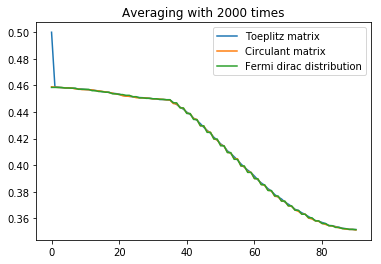

In [105]:
L=91
M=Covariance_matrix_from_sub_sample(Data[0,:,0],Data[0,:,1],L=L)
for i in range(1,2000):
    #print(i)
    M+=Covariance_matrix_from_sub_sample(Data[i,:,0],Data[i,:,1],L=L)
    S=np.linalg.svd(M,compute_uv=False)
    M_corner=np.zeros((L,L))
    M_corner[0,L-1],M_corner[L-1,0]=M[1,0].real, M[0,1].real
    S_circulant=np.linalg.svd(M+M_corner,compute_uv=False)
    if (i+1)%3==0:
        clear_output(wait=True)
        plt.plot(sorted(-S/(i+1)+0.5,reverse=True),label="Toeplitz matrix")
        plt.plot(sorted(-S_circulant/(i+1)+0.5,reverse=True),label="Circulant matrix")
        n=np.arange(-(L-1)/2,(L-1)/2 +1)
        f=Fermi_dirac(beta=0.40824,mu=0,n=n,Gamma=Gamma,Lambda=Lambda,N=L)
        plt.plot(sorted(f,reverse=True),label="Fermi dirac distribution")
        #plt.plot(S/(i+1))
        plt.title("Averaging with {} times".format(i+1))
        plt.legend()
        plt.show()

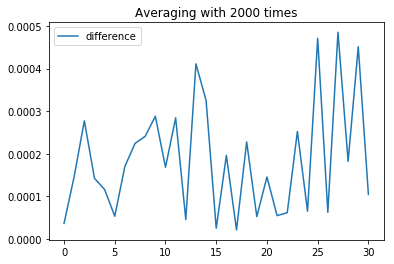

In [108]:
L=31
M=Covariance_matrix_from_sub_sample(Data[0,:,0],Data[0,:,1],L=L)
for i in range(1,2000):
    #print(i)
    M+=Covariance_matrix_from_sub_sample(Data[i,:,0],Data[i,:,1],L=L)
    S=np.linalg.svd(M,compute_uv=False)
    M_corner=np.zeros((L,L))
    M_corner[0,L-1],M_corner[L-1,0]=M[1,0].real, M[0,1].real
    S_circulant=np.linalg.svd(M+M_corner,compute_uv=False)
    if (i+1)%100==0:
        clear_output(wait=True)
        #plt.plot(sorted(-S/(i+1)+0.5,reverse=True),label="Toeplitz matrix")
        #plt.plot(sorted(-S_circulant/(i+1)+0.5,reverse=True),label="Circulant matrix")
        n=np.arange(-(L-1)/2,(L-1)/2 +1)
        f=Fermi_dirac(beta=0.40824,mu=0,n=n,Gamma=Gamma,Lambda=Lambda,N=L)
        plt.plot(np.abs(np.array(sorted(f,reverse=True))-np.array(sorted(-S_circulant/(i+1)+0.5,reverse=True))),label="difference")
        plt.title("Averaging with {} times".format(i+1))
        plt.legend()
        plt.show()    

In [125]:
results=[]
for L in range(31,551,2):
    M=Covariance_matrix_from_sub_sample(Data[0,:,0],Data[0,:,1],L=L)
    for i in range(1,2000):
        #print(i)
        M+=Covariance_matrix_from_sub_sample(Data[i,:,0],Data[i,:,1],L=L)
        #S=np.linalg.svd(M,compute_uv=False)
        M_corner=np.zeros((L,L))
        M_corner[0,L-1],M_corner[L-1,0]=M[1,0].real, M[0,1].real
        S_circulant=np.linalg.svd(M+M_corner,compute_uv=False)
    n=np.arange(-(L-1)/2,(L-1)/2 +1)
    f=Fermi_dirac(beta=0.40824,mu=0,n=n,Gamma=Gamma,Lambda=Lambda,N=L)
    tmp=np.abs(np.array(sorted(f,reverse=True))-np.array(sorted(-S_circulant/(2000)+0.5,reverse=True)))
    results.append(np.mean(tmp))

KeyboardInterrupt: 

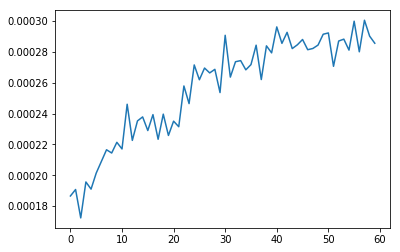

In [116]:
plt.plot(results)

In [117]:
from scipy.optimize import curve_fit

In [118]:
def f1(x,a,b):
    return a*x+b
def f2(x,a,b):
    return a*np.sqrt(x)+b

In [121]:
popt_1,pcov_1=curve_fit(f1,range(31,151,2),results)
popt_2,pcov_2=curve_fit(f2,range(31,151,2),results)

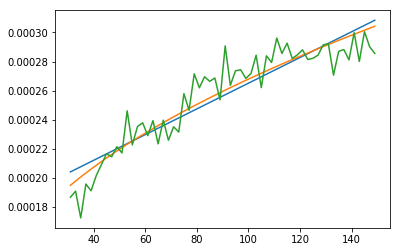

In [124]:
plt.plot(range(31,151,2),f1(range(31,151,2),*popt_1),label="linear")
plt.plot(range(31,151,2),f2(range(31,151,2),*popt_2),label="linear")
plt.plot(range(31,151,2),results)

In [126]:
popt_1

array([8.84629144e-07, 1.76618646e-04])

In [127]:
popt_2

array([1.64916732e-05, 1.02971448e-04])